Imputing scRNA-seq data with MAGIC<br>
Paper: <a href="http://www.biorxiv.org/content/early/2017/02/25/111591">MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data</a><br>
Code: https://github.com/pkathail/magic<br>

In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn
import pandas as pd

In [2]:
# load data
df = pd.DataFrame.from_csv('~/Downloads/HMLE_full.csv.gz', header=0, sep=',', index_col=None)

In [3]:
# library size normalization
data = df.as_matrix()
lib_size = data.sum(axis=1)
data = data / lib_size[:,None] # divide by library size
data = data * np.median(lib_size) # multiply by median library size
df = pd.DataFrame(data=data, columns=df.columns.tolist())

In [4]:
# MAGIC params
npca = 20 # for computting distances
k = 10; # k-th nearest neighbor for adaptive kernel bandwidth
a = 10; # decay rate of kernel; 2 is standard Gaussian kernel
t = 6 # number of steps to diffuse

In [5]:
# PCA
pca = PCA(n_components=npca, svd_solver='randomized') # fast random PCA
pc = pca.fit_transform(data)

In [6]:
# compute kernel and operator
pdx = squareform(pdist(pc, metric='euclidean')) # compute distances on pca
knn_dst = np.sort(pdx, axis=1) # get knn distances for adaptive kernel
epsilon = knn_dst[:,k] # bandwidth(x) = distance to k-th neighbor of x
pdx = (pdx / epsilon).T # autotuning d(x,:) using epsilon(x).
gs_ker = np.exp(-1 * ( pdx ** a)) # alpha decaying Gaussian kernel: exp(-D^alpha)
gs_ker = gs_ker + gs_ker.T # symmetrization
diff_deg = np.diag(np.sum(gs_ker,0)) # degrees
diff_op = np.dot(np.diag(np.diag(diff_deg)**(-1)),gs_ker) # row stochastic -> Markov operator

In [7]:
# impute
diff_op_t = np.linalg.matrix_power(diff_op, t) # diffuse t steps by powering the operator
data_new = np.array(np.dot(diff_op_t, data)) # multiply diffused operator with data
df_new = pd.DataFrame(data=data_new, columns=df.columns.tolist())

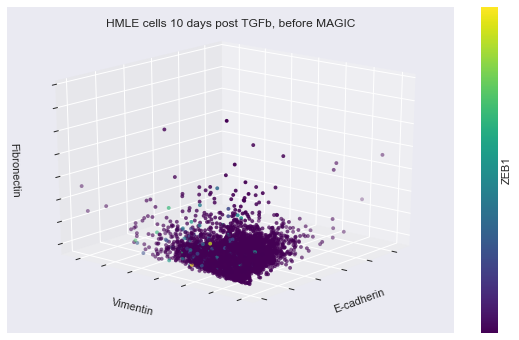

In [44]:
# plot data before MAGIC
x = df["CDH1"]
y = df["VIM"]
z = df["FN1"]
c = df["ZEB1"]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.setp(ax, xticklabels=[], yticklabels=[], zticklabels=[])
im = ax.scatter(x, y, z, s=15, linewidths=0, c=c, cmap=cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label('ZEB1')
ax.set_xlabel("E-cadherin")
ax.set_ylabel("Vimentin")
ax.set_zlabel("Fibronectin")
ax.set_title("HMLE cells 10 days post TGFb, before MAGIC")
ax.view_init(20, 220)
plt.show()

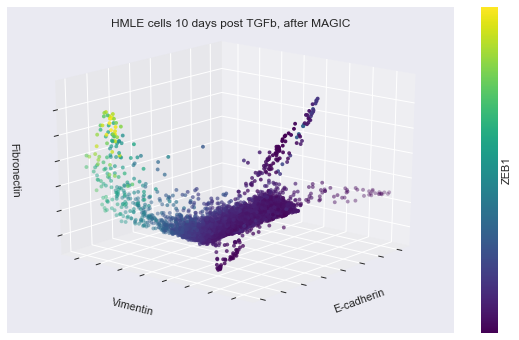

In [45]:
# plot data after MAGIC
x = df_new["CDH1"]
y = df_new["VIM"]
z = df_new["FN1"]
c = df_new["ZEB1"]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.setp(ax, xticklabels=[], yticklabels=[], zticklabels=[])
im = ax.scatter(x, y, z, s=15, linewidths=0, c=c, cmap=cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([])
cbar.set_label('ZEB1')
ax.set_xlabel("E-cadherin")
ax.set_ylabel("Vimentin")
ax.set_zlabel("Fibronectin")
ax.set_title("HMLE cells 10 days post TGFb, after MAGIC")
ax.view_init(20, 220)
plt.show()